Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading model...
Loading input image: /content/drive/MyDrive/DATASET/COLORIZE/images/nature.jpg
Colorizing the image...
Displaying results...


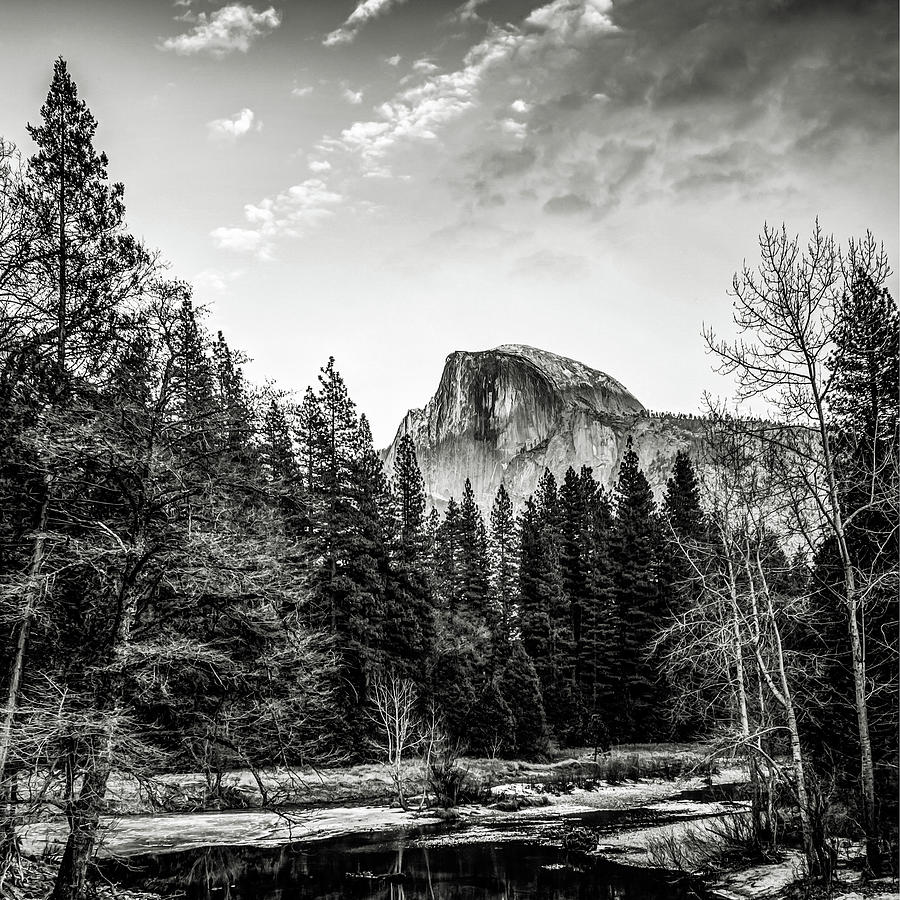

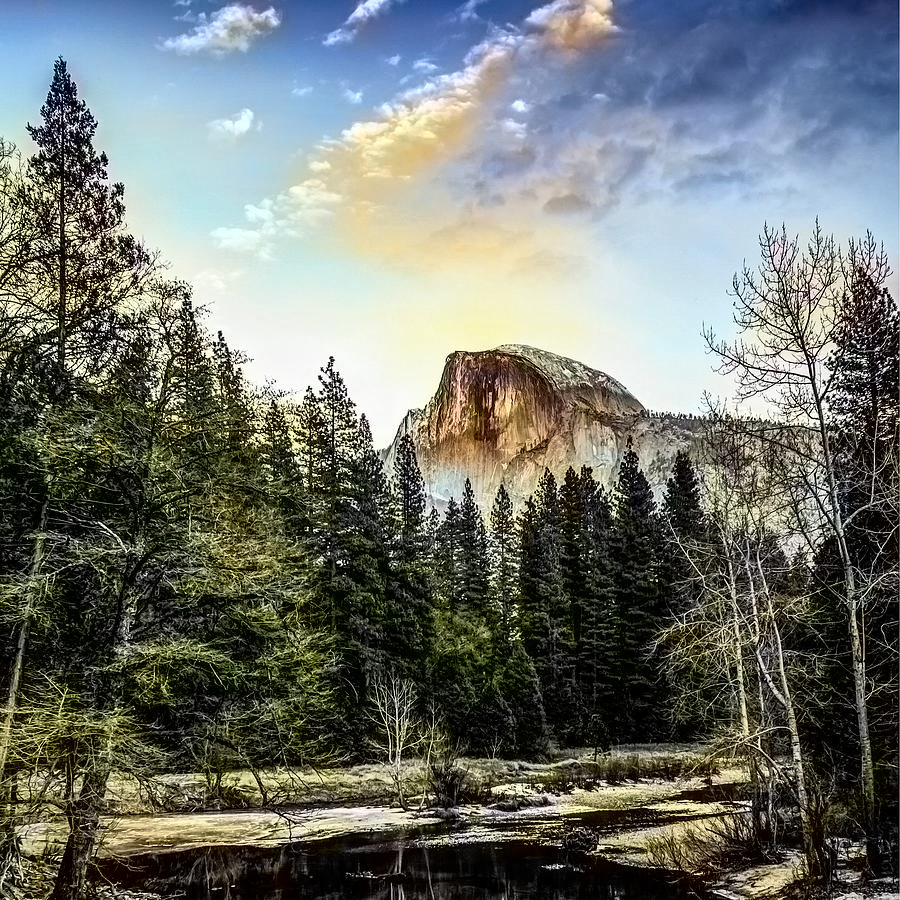

In [3]:
# Import statements
import numpy as np
import cv2
import os
from google.colab.patches import cv2_imshow
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Paths to load the model (update these paths based on your Google Drive structure)
DIR = "/content/drive/MyDrive/DATASET/COLORIZE"
PROTOTXT = os.path.join(DIR, "model/colorization_deploy_v2.prototxt")
POINTS = os.path.join(DIR, "model/pts_in_hull.npy")
MODEL = os.path.join(DIR, "model/colorization_release_v2.caffemodel")

# Hard-coded input image path (update based on your image location in Google Drive)
INPUT_IMAGE = "/content/drive/MyDrive/DATASET/COLORIZE/images/nature.jpg"

# Load the Model
print("Loading model...")
net = cv2.dnn.readNetFromCaffe(PROTOTXT, MODEL)
pts = np.load(POINTS)

# Load centers for ab channel quantization used for rebalancing
class8 = net.getLayerId("class8_ab")
conv8 = net.getLayerId("conv8_313_rh")
pts = pts.transpose().reshape(2, 313, 1, 1)
net.getLayer(class8).blobs = [pts.astype("float32")]
net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]

# Load the input image
print(f"Loading input image: {INPUT_IMAGE}")
image = cv2.imread(INPUT_IMAGE)
if image is None:
    raise ValueError("Image not found or path is incorrect. Please check INPUT_IMAGE.")

scaled = image.astype("float32") / 255.0
lab = cv2.cvtColor(scaled, cv2.COLOR_BGR2LAB)

resized = cv2.resize(lab, (224, 224))
L = cv2.split(resized)[0]
L -= 50

# Colorize the image
print("Colorizing the image...")
net.setInput(cv2.dnn.blobFromImage(L))
ab = net.forward()[0, :, :, :].transpose((1, 2, 0))

ab = cv2.resize(ab, (image.shape[1], image.shape[0]))

L = cv2.split(lab)[0]
colorized = np.concatenate((L[:, :, np.newaxis], ab), axis=2)

colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2BGR)
colorized = np.clip(colorized, 0, 1)

colorized = (255 * colorized).astype("uint8")

# Display the images
print("Displaying results...")
cv2_imshow(image)  # Original Image
cv2_imshow(colorized)  # Colorized Image
